# **Exploratory Data Analysis**

Throughout the Exploratory Data Analysis (EDA) presented in the following, we will be looking at the Spacecraft Pose Estimation Dataset (SPEED) to determine the best way to prepare it for further processing by a deep learning model. The purpose of the EDA is to better understand the existing patterns in data in order to define a proper pipeline.

### **A brief look at the dataset**

First, let's check the dataset directory. In the `DATASET_PATH` constant I set the local path where I stored the dataset downloaded at the link below.

https://kelvins.esa.int/satellite-pose-estimation-challenge/data

Note in the result of `tree` command that the `images` directory contain satellite images divided into four subsets: `real`, `real_test`, `test` and `train`. Outside this folder, there are four `.json`files corresponding to their respective label associations.

In [1]:
import os

DATASET_PATH = "/home/lfgodoi/Documentos/Datasets/Spacecraft Pose Estimation Dataset (SPEED)/data"
os.system(f"tree -L 2 '{DATASET_PATH}'")

/home/lfgodoi/Documentos/Datasets/Spacecraft Pose Estimation Dataset (SPEED)/data
├── images
│   ├── real
│   ├── real_test
│   ├── test
│   └── train
├── LICENSE.MD
├── real.json
├── real_test.json
├── test.json
└── train.json

6 directories, 5 files


0

For this data exploratory analysis, we will use a few random images from the `train`subset. Let's start by listing the name of all files existing in this folder.

In [2]:
TRAIN_SUBSET_PATH = f"{DATASET_PATH}/images/train"
train_file_names = os.listdir(TRAIN_SUBSET_PATH)

From the file name list, we then randomly select four images to proceed with our investigation

In [3]:
import numpy as np
import cv2 as cv

selected_files = np.random.randint(0, len(train_file_names), 4)
selected_files.sort()
images = {}
for filename in selected_files:
    image = cv.imread(f"{TRAIN_SUBSET_PATH}/{train_file_names[filename]}", cv.IMREAD_GRAYSCALE)
    images[filename] = image
f"Imagens selecionadas: {selected_files}"

'Imagens selecionadas: [  198  3297  7977 10779]'

Let's take a look at the images we just selected.

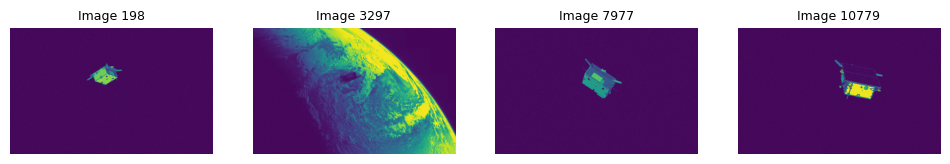

In [4]:
import matplotlib.pyplot as plt

def display_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 8))
    for i, (filename, image) in enumerate(images.items()):
        axes[i].imshow(image)
        axes[i].set_title(f"Image {filename}", fontsize=9)
        axes[i].axis("off")

display_images(images)

### **Enhancing Image Quality**

The satellite is the element of interest in every image, but distinguishing it from other elements present is not so easy. An efficient way to visualize this is through the histogram, which plots the distribution of pixel intensity values in relation to the 256 possible values (0 to 255). Sparsely distributed intensities, concentrated in a limited range of values, imply a low level of contrast, making it difficult to distinguish the elements that make up the image.

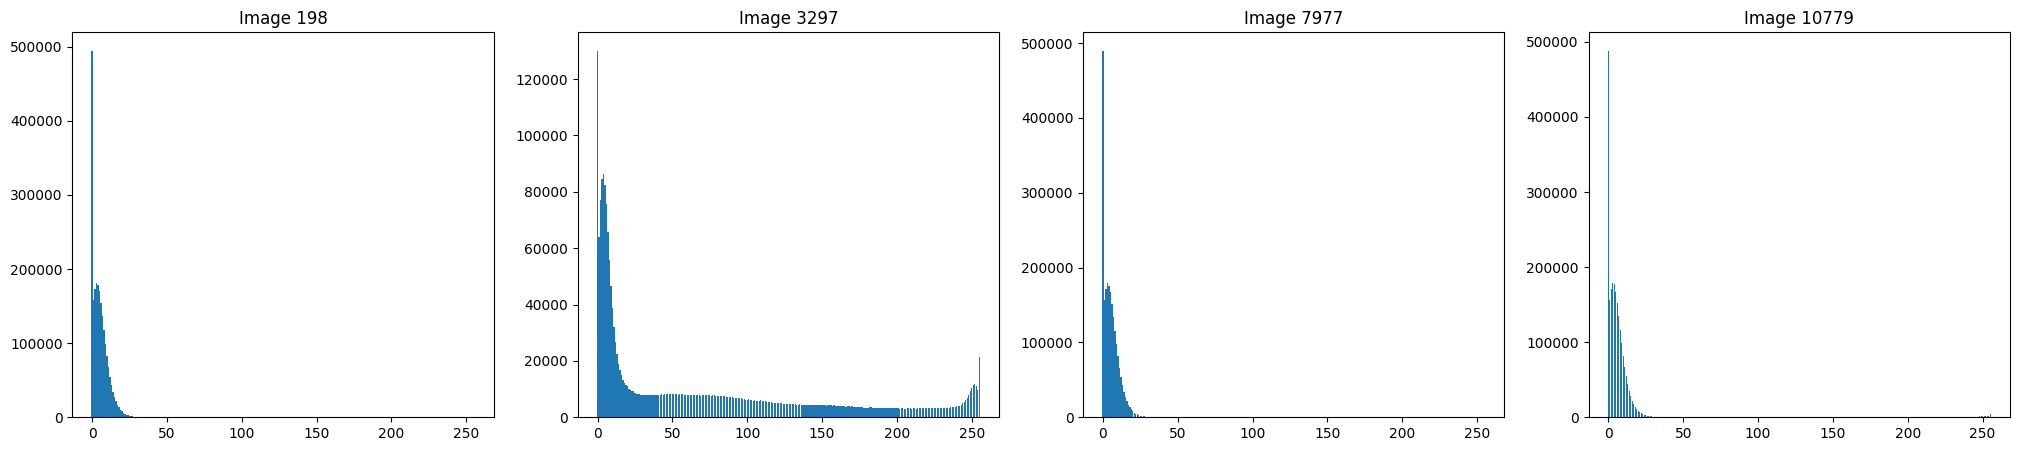

In [5]:
def compute_histograms(images):
    histograms = {}
    for filename, image in images.items():
        histogram = cv.calcHist([image], [0], None, [256], [0, 256])
        histograms[filename] = histogram
    return histograms

histograms = compute_histograms(images)

def plot_histograms(histograms):
    fig, axes = plt.subplots(1, len(images), figsize=(25, 5))
    for i, (filename, histogram) in enumerate(histograms.items()):
        axes[i].bar(np.arange(256), histogram[:, 0])
        axes[i].set_title(f"Image {filename}", fontsize=12)

plot_histograms(histograms)

To mitigate this effect, we will apply histogram equalization, which consists of flattening the distribution of histograms, expanding the variation of intensities in order to facilitate the visual distinction of the different elements. The Contrast Limited Adaptive Histogram Equalization (CLAHE) is a sophisticated technique that equalizes pixels in a local perspective rather than in the global approach used by more common techniques, by dividing the whole image into small blocks called "tiles".

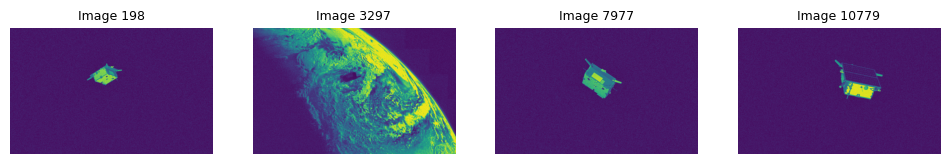

In [6]:
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized_images = {}
for filename, image in images.items():
    equalized_image = clahe.apply(image)
    # equalized_image = cv.equalizeHist(image)
    equalized_images[filename] = equalized_image

display_images(equalized_images)

And the equalized histograms look like...

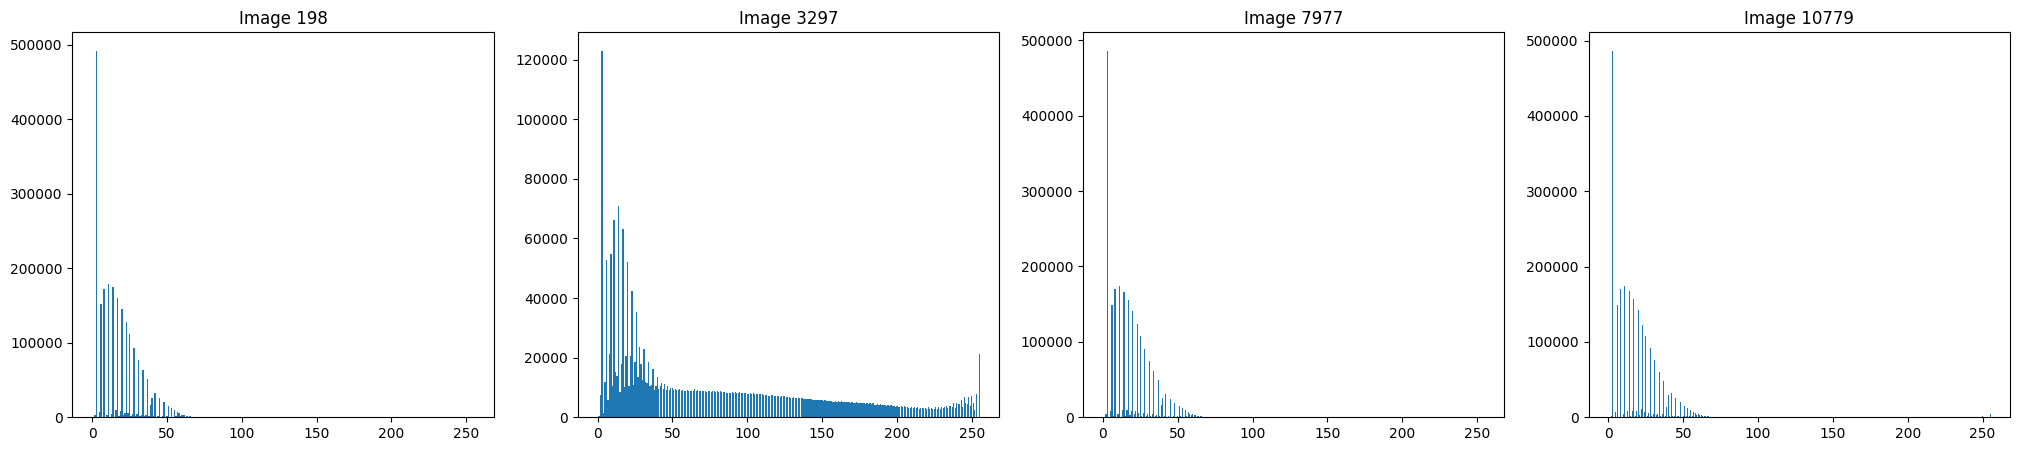

In [7]:
equalized_histograms = compute_histograms(equalized_images)
plot_histograms(equalized_histograms)

Next, we apply image sharpening to enhance the edges and fine details in an image by increasing the contrast between adjacent pixels.

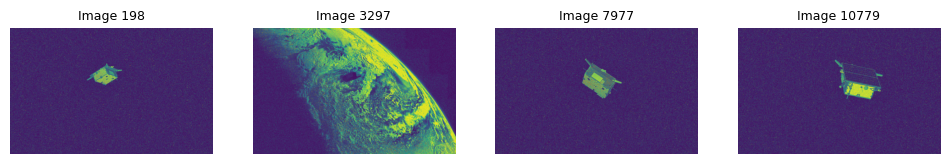

In [8]:
sharpened_equalized_images = {}
for filename, equalized_image in equalized_images.items():
    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    sharpened_equalized_image = cv.filter2D(equalized_image, -1, sharpening_kernel)
    sharpened_equalized_images[filename] = sharpened_equalized_image

display_images(sharpened_equalized_images)

Finally, we increase the image contrast by assigning alpha, the contrast control coefficient, a value greater than 1. Beta equal to 1 means keeping the brightness unchanged.

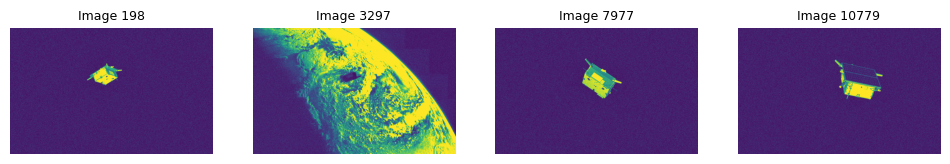

In [10]:
enhanced_images = {}
for filename, sharpened_equalized_image in equalized_images.items():
    enhanced_image = cv.convertScaleAbs(sharpened_equalized_image, alpha=1.5, beta=1.0)
    # enhanced_image = cv.addWeighted(sharpened_equalized_image, 1.5, sharpened_equalized_image, 0, 1.0)
    enhanced_images[filename] = enhanced_image

display_images(enhanced_images)